# **Download Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!ls

In [ ]:
# unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

# **Import libraries**

In [269]:
# General libraries
import os
from os.path import dirname as up
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import random
import cv2
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import required libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version: {}".format(tf.__version__), end='\n'"Keras Version:  {}".format(keras.__version__))

TensorFlow Version: 2.4.0-dev20200901
Keras Version:  2.4.0

# Implementation Of Binary Classification Model

In [270]:
## Input Path ##
# input_path = "/content/gdrive/My Drive/Kaggle/chest_xray/"
input_path = '../PneumoniaDetection/chest_xray/'

# Dataset

Saving figure Pneumonia Dataset
Saving figure Pneumonia Dataset
Saving figure Pneumonia Dataset


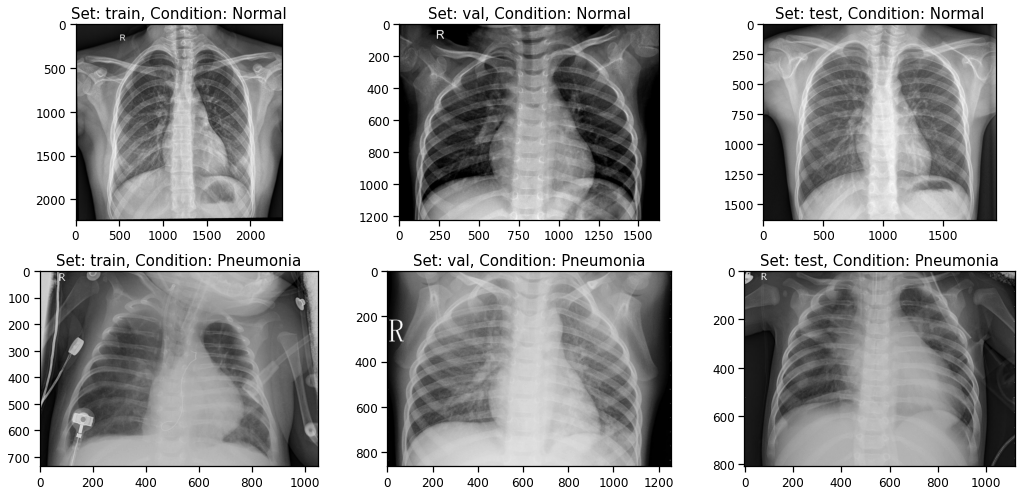

In [271]:
## Plot Pneumonia Dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
#     save_fig('Binary Classification of Pneumonia Dataset')

In [272]:
# Datasets Distribution
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    n_total = n_normal + n_infect
    print('{} case count: {}, Normal: {}, Pneumonia: {}'.format(_set, n_total, n_normal, n_infect))

train case count: 5216, Normal: 1341, Pneumonia: 3875
val case count: 16, Normal: 8, Pneumonia: 8
test case count: 624, Normal: 234, Pneumonia: 390


# Image Data Augmentation

In [273]:
# Data generation objects
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
    
# This is fed to the network in the specified batch sizes and image dimensions
training_set = train_datagen.flow_from_directory(input_path+'test',
                                                 target_size = (64, 64), 
                                                 batch_size = 32,
                                                 class_mode = 'binary')
    
test_set = test_datagen.flow_from_directory(input_path+'train',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [311]:
# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
  for img in (os.listdir(input_path + 'test' + cond)):
    img = plt.imread(input_path+'test'+cond+img)
    img = cv2.resize(img, (64, 64))
    img = np.dstack([img, img, img])
    img = img.astype('float32') / 255
    if cond=='/NORMAL/':
      label = 0
    elif cond=='/PNEUMONIA/':
      label = 1
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [275]:
# Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [276]:
## Metrics for Model

METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')
]

# Define CNN Model

In [277]:
# keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

## Initialising the CNN
classifier = Sequential()

## First Convolution layer of 32 filter maps by applying 32 filters (feature detectors)
# Input Shape is the desired size of the image 64x64 with 3 bytes color
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))  

# Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Second Convolutional layer of 64 filter
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Third Convolutional layer of 128 filter
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Fully Connected layer with 2 hidden layer(128 Neuron)
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 128, activation = 'relu'))

# Output layer(Only 1 Output Neuron). 
# It will contain a value from 0-1 where 0 for ('Normal') class & 1 for ('Pneumonia') class
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN 
classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = METRICS) 

# Training and Evaluating the Model
history = classifier.fit(training_set, 
                         steps_per_epoch = 500 // 32, 
                         epochs = 200, 
                         validation_data = test_set, 
                         validation_steps = 125 // 32)


Epoch 1/200
15/15 [==============================] - 28s 2s/step - loss: 0.7183 - tp: 117.1250 - fp: 69.7500 - tn: 31.6875 - fn: 46.4375 - accuracy: 0.5360 - precision: 0.5984 - recall: 0.6350 - auc: 0.5175 - val_loss: 0.6239 - val_tp: 73.0000 - val_fp: 23.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7604 - val_precision: 0.7604 - val_recall: 1.0000 - val_auc: 0.4616
Epoch 2/200
15/15 [==============================] - 21s 1s/step - loss: 0.6623 - tp: 166.7500 - fp: 93.2500 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.6496 - precision: 0.6496 - recall: 1.0000 - auc: 0.5187 - val_loss: 0.5234 - val_tp: 76.0000 - val_fp: 20.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7917 - val_precision: 0.7917 - val_recall: 1.0000 - val_auc: 0.6372
Epoch 3/200
15/15 [==============================] - 31s 2s/step - loss: 0.6379 - tp: 152.8750 - fp: 79.5000 - tn: 18.5000 - fn: 19.1250 - accuracy: 0.6462 - precision: 0.6633 - recall: 0.9185 - auc: 0.5860 - val_l

In [279]:
# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch. 
epochs = history.epoch
hist = pd.DataFrame(history.history)

Saving figure metrics vs. epoch with rmsprop
Saving figure metrics vs. epoch with rmsprop


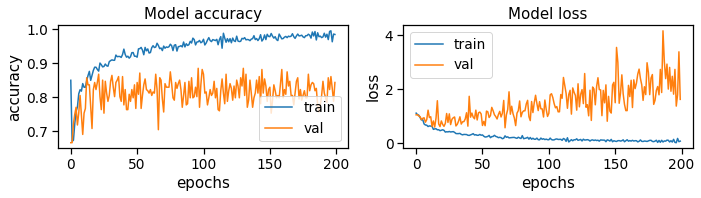

In [308]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    save_fig('metrics vs. epoch with rmsprop')

In [316]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = classifier.predict(test_data)

accuracy = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()


print('**** CONFUSION MATRIX with rmsprop for 200epoch ****')
print(cm)

print('\n**** TEST METRICS with rmsprop for 200 epochs ****')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
Specificity = tn/(tn+fp)*100
f1 = 2*precision*recall/(precision+recall)
print('Accuracy:  {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall(Sensitivity): {}%'.format(recall))
print('F1-score:  {}'.format(f1))
print('Specificity: {}'. format(Specificity))

print('\n**** TRAIN METRICS with rmsprop for 200 epochs ****')
print('Accuracy:  {}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

**** CONFUSION MATRIX with rmsprop for 200epoch ****
[[234   0]
 [  7 383]]

**** TEST METRICS with rmsprop for 200 epochs ****
Accuracy:  98.87820512820514%
Precision: 100.0%
Recall(Sensitivity): 98.2051282051282%
F1-score:  99.09443725743854
Specificity: 100.0

**** TRAIN METRICS with rmsprop for 200 epochs ****
Accuracy:  98.49%


In [319]:
## Save the Model
classifier.save('pneumonia_binary_200epochs_rmsprop.h5')

In [296]:
## Make it Resuable
classifier.save_weights('pneumonia_binary_200epochs_rmsprop_weights.h5')

In [298]:
## Save the Model to JSON
classifier_json = classifier.to_json()
with open('pneumonia_binary_200_epochs_rmsprop.json', 'w') as json_file:
    json_file.write(classifier_json)

# Implementation Of 3-Class Classification Model

In [288]:
input_path1 = '../PneumoniaDetection/chest_xray_cat/'

# Dataset

Saving figure Multi-Class Pneumonia Dataset
Saving figure Multi-Class Pneumonia Dataset


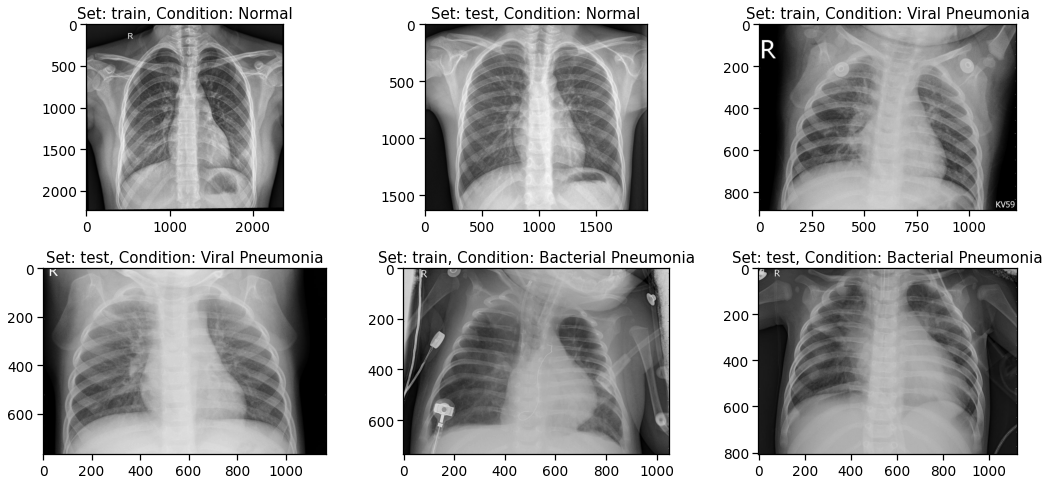

In [289]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = input_path1+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/VIRAL PNEUMONIA/'+os.listdir(set_path+'/VIRAL PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Viral Pneumonia'.format(_set))
    ax[i+4].imshow(plt.imread(set_path+'/BACTERIAL PNEUMONIA/'+os.listdir(set_path+'/BACTERIAL PNEUMONIA')[0]), cmap='gray')
    ax[i+4].set_title('Set: {}, Condition: Bacterial Pneumonia'.format(_set))
    save_fig('Multi-Class Pneumonia Dataset')

In [290]:
# Distribution of our datasets
for _set in ['train', 'test']:
    n_normal = len(os.listdir(input_path1 + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path1 + _set + '/VIRAL PNEUMONIA'))
    n_bacteria = len(os.listdir(input_path1 + _set + '/BACTERIAL PNEUMONIA'))
    n_total = n_normal + n_infect + n_bacteria
    print('{} case count: {}, Normal: {}, Viral Pneumonia: {}, Bacterial Pneumonia: {}'.format(_set, n_total, n_normal, n_infect, n_bacteria))

train case count: 5234, Normal: 1349, Viral Pneumonia: 1346, Bacterial Pneumonia: 2539
test case count: 624, Normal: 234, Viral Pneumonia: 148, Bacterial Pneumonia: 242


# Image Data Augmentation

In [294]:
# Data generation objects
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
    
# This is fed to the network in the specified batch sizes and image dimensions
training_set = train_datagen.flow_from_directory(input_path1+'test',
                                                 target_size = (64, 64), 
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
    
test_set = test_datagen.flow_from_directory(input_path1+'train',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 3 classes.
Found 5232 images belonging to 3 classes.


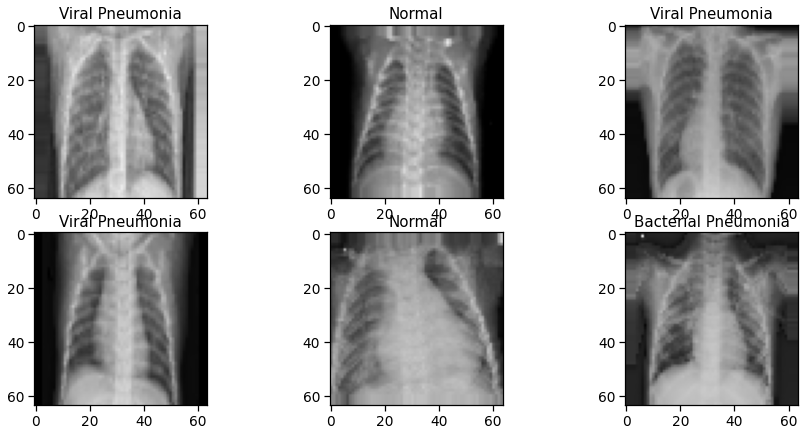

In [382]:
# preview images from train generator
classtolabel = {'0':'Normal','1':'Viral Pneumonia','2':'Bacterial Pneumonia'}
for x in training_set:
    fig, axes = plt.subplots(2, 3, figsize=(15,7))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break


# Define CNN Model

In [295]:
# keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

# Initialising the CNN
classifier1 = Sequential()

# First Convolution layer - Input Shape is the desired size of the image 64x64 with 3 bytes color
classifier1.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))  

# Pooling
classifier1.add(MaxPooling2D(pool_size = (2, 2)))

# Second Convolutional layer
classifier1.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier1.add(MaxPooling2D(pool_size = (2, 2)))

# Third Convolutional layer
classifier1.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier1.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier1.add(Flatten())

# Full Connection layer with 2 hidden layer(128 Neuron)
classifier1.add(Dense(units = 128, activation = 'relu'))
classifier1.add(Dense(units = 128, activation = 'relu'))

# Output layer(Only 1 Output Neuron). 
# It will contain a value from 0-1 where 0 for ('Normal') class & 1 for ('Pneumonia') class
classifier1.add(Dense(units = 3, activation = 'softmax'))

# Compiling the CNN 
classifier1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = METRICS) 

# Training and Evaluating the Model
history = classifier1.fit(training_set, 
                         steps_per_epoch = 500 // 32, 
                         epochs = 200, 
                         validation_data = test_set, 
                         validation_steps = 125 // 32)


Epoch 1/200
15/15 [==============================] - 41s 3s/step - loss: 1.1497 - tp: 395.8750 - fp: 19.8750 - tn: 734.1250 - fn: 254.1250 - accuracy: 0.8972 - precision: 0.9525 - recall: 0.6378 - auc: 0.8782 - val_loss: 1.0500 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 192.0000 - val_fn: 96.0000 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6566
Epoch 2/200
15/15 [==============================] - 19s 1s/step - loss: 1.0671 - tp: 18.5625 - fp: 14.8125 - tn: 513.1875 - fn: 245.4375 - accuracy: 0.6703 - precision: 0.4564 - recall: 0.0490 - auc: 0.6216 - val_loss: 1.0547 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 192.0000 - val_fn: 96.0000 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7424
Epoch 3/200
15/15 [==============================] - 21s 1s/step - loss: 1.0428 - tp: 32.7500 - fp: 32.3125 - tn: 491.6875 - fn: 229.2500 - accuracy: 0.6682 - precision: 0.4880 - recall: 0.1253 - auc

In [326]:
# # Evaluate CNN Performance
classifier1.evaluate(test_set, batch_size = 32)

164/164 [==============================] - 445s 3s/step - loss: 2.0569 - tp: 3731.0000 - fp: 1472.0000 - tn: 8992.0000 - fn: 1501.0000 - accuracy: 0.8106 - precision: 0.7171 - recall: 0.7131 - auc: 0.8439


In [ ]:
## Save the Model
classifier1.save('pneumonia_3class_200epochs_rmsprop.h5')

In [304]:
## Make it Resuable
classifier1.save_weights('pneumonia_3class_200epochs_rmsprop_weights.h5')
# classifier.save_weights('pneumonia_weights_rmsprop.ckpt')

In [305]:
## Save the Model to JSON
classifier_json = classifier1.to_json()
with open('pneumonia_3class_200epochs_rmsprop.json', 'w') as json_file:
    json_file.write(classifier_json)